PHO Vinh-Son 3802052

# Rapport Projet ML

In [178]:
from projet import *
from mltools import *

#seulement pour mnist
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [179]:
def confusion_mat(y_true,y_pred):
    N = y_true.size
    C = 10
    conf = np.zeros((C,C))
    for i in range(N):
        conf[y_pred[i],y_true[i]] += 1
    plt.imshow(conf)
    plt.colorbar()
    plt.xlabel("Vérité")
    plt.ylabel("Prédiction")

## Partie 1, 2 et 3 Briques de base

On teste un réseau de neurone simple sur des données linéairement séparables.

In [7]:
N = 500
x_train,y_train = gen_arti(nbex = N) #données jouets linéairement séparables

net = Sequentiel(MSELoss()) #on utilise le coût des moindres carrés
net.build_network([2,3,1],[Tanh(),Sigmoide()]) #le réseau a 2 couches, Linear(2,3) -> Tanh -> Linear(3,1) -> Sigmoid
opt = Optim(net,1e-1) #on prend un pas de gradient de 1e-1

In [8]:
SGD(opt,x_train,y_train,64,5) #on train sur 5 itérations de sur des batch de 64

epoch : 1/5
erreur :  0.7942640555473353
epoch : 2/5
erreur :  0.5559783687503438
epoch : 3/5
erreur :  0.5306101100916868
epoch : 4/5
erreur :  0.5169742791502939
epoch : 5/5
erreur :  0.5135952203499964


On voit que l'erreur descent bien.

On teste maintenant le réseau de neurone sur un problème XOR.

In [172]:
x_train = np.array([[0,0], [0,1], [1,0], [1,1]])
y_train = np.array([0, 1, 1, 0])

net = Sequentiel(MSELoss())
net.build_network([2,3,1],[Tanh(),Tanh()])
opt = Optim(net,1e-1) 

In [173]:
SGD(opt,x_train,y_train,4,1000,verbose = False)

In [177]:
pred = np.array(net.forward(x_train))
np.mean(np.round(pred).reshape(-1) == y_train)

1.0

On voit qu'on arrive apprendre le problème du XOR avec ce réseau de neurone.

## Partie 4 Multiclasse

On vérifie maintenant que le multiclasse fonctionne bien correctement.

In [324]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #données des chiffres MNIST

#Transformation des classes en One-Hot
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)
y_train = y_train.reshape(y_train.shape[0],10)
y_test = y_test.reshape(y_test.shape[0],10)

#on transforme les image (28,28) en vecteur de 28*28 dimensions
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_test = x_test.reshape(x_test.shape[0], 28*28)

#reseau de neurone 3 couches de 100,50,10 neurones
#pas de log
net = Sequentiel(OGCELoss())
net.build_network([28*28,100,50,10],[Tanh(),Tanh(),SoftMax()])
opti = Optim(net,1e-3)

#avec log + sigmoide
netlog = Sequentiel(CELoss())
netlog.build_network([28*28,100,50,10],[Tanh(),Tanh(),Sigmoide()])
optilog = Optim(netlog,1)

In [325]:
SGD(opti,x_train,y_train, 60, 30,verbose = False)

taux pred: 0.8862


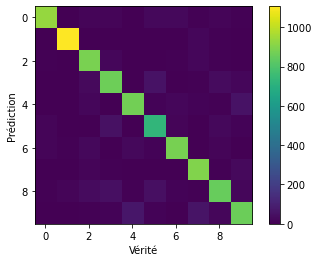

In [326]:
out = net.forward(x_test.reshape(-1,1,784))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

On peut voir qu'on arrive très bien a apprendre le problème des chiffres manuscrit avec un réseau de neurone assez simple, avec un SoftMax en activation et une Loss : $CE(y,pred) = -pred_y$

In [327]:
SGD(optilog,x_train,y_train, 60, 30,verbose = False)

taux pred: 0.8091


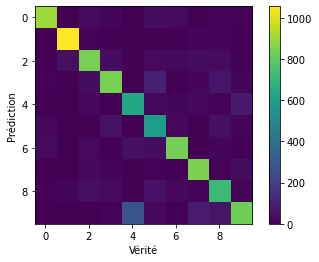

In [328]:
out = netlog.forward(x_test)
pred = np.argmax(out, axis = 1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

On peut aussi l'apprendre avec une sigmoide en fonction d'activation finale combinée avec la CELoss donnée dans le sujet. $CE(y,pred) = -log \frac{e^{pred_y}}{\sum_{i}e^{pred_i}} $

## Partie 5 AutoEncoder

In [216]:
#Chargement des données
uspsdatatrain = "USPS_train.txt"
uspsdatatest = "USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
#on passe de [0,2] à [0,1]
alltrainx = alltrainx/2
alltestx = alltestx/2

In [181]:
#AutoEncoder suggéré (Baseline)
AE = AutoEncoder(BCELoss())
AE.build([256,100,10],[10,100,256],[Tanh(),Tanh()],[Tanh(),Sigmoide()])
OptAE = Optim(AE,1e-4)

In [182]:
SGD(OptAE,alltrainx,alltrainx,20,200,lr = 1e-5,verbose = False) #200 epochs, 20 batches

In [183]:
code = AE.encode(alltestx)
uncomp = AE.decode(code)

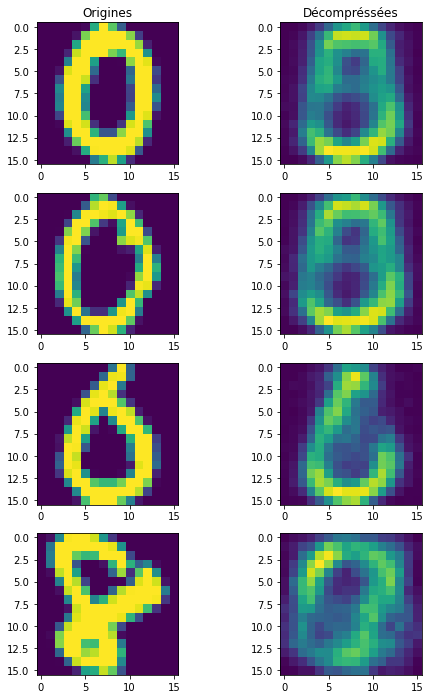

In [184]:
N = alltestx.shape[0]
L = 4
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompréssées")
for i in range(L):
    rand = np.random.randint(N)
    axs[i,0].imshow(alltestx[rand].reshape((16,16)))
    axs[i,1].imshow(uncomp[rand].reshape((16,16)))

plt.show()

On peut voir que pour certaines images la compression ne fait pas perdre tant d'information, mais pour d'autre on arrive même plus à lire le chiffre.

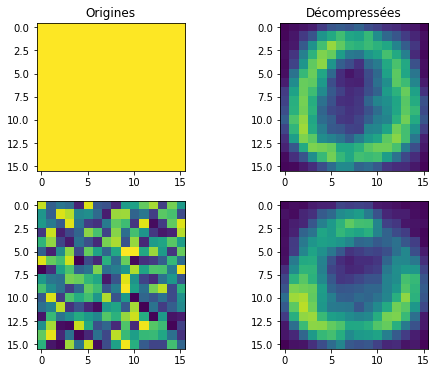

In [185]:
testimg1 = np.ones(16*16)
testimg2 = np.random.uniform(0,1,16*16)

testimgs = [testimg1,testimg2]

testcode = AE.encode(testimgs)
testuncomp = AE.decode(testcode)

L = 2
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompressées")
for i in range(L):
    axs[i,0].imshow(testimgs[i].reshape((16,16)),vmin = 0,vmax = 1)
    axs[i,1].imshow(testuncomp[i].reshape((16,16)),vmin = 0,vmax = 1)


On remarque que l'AutoEncoder est vraiment propre au problème car en compressant décompressant une image blanche et une image aléatoire, on retrouve une image de 0, c'est à dire la classe majoritaire dans les données.

## Expérimentation sur les différents paramètres

### Etude qualitative

On peut tenter de modifier certains paramètres: comme le taux de crompression, le nombre de couche ou même la fonction d'activation

In [187]:
#AutoEncoder à tester
AE1 = AutoEncoder(BCELoss())
AE1.build([256,100,16],[16,100,256],[Tanh(),Tanh()],[Tanh(),Sigmoide()])
OptAE1 = Optim(AE1,1e-4)

AE2 = AutoEncoder(BCELoss())
AE2.build([256,100,50,10],[10,50,100,256],[Tanh(),Tanh(),Tanh()],[Tanh(),Tanh(),Sigmoide()])
OptAE2 = Optim(AE2,1e-4)

AE3 = AutoEncoder(BCELoss())
AE3.build([256,100,6],[6,100,256],[Tanh(),Tanh()],[Tanh(),Sigmoide()])
OptAE3 = Optim(AE3,1e-4)


In [188]:
SGD(OptAE1,alltrainx,alltrainx,20,200,lr = 1e-5,verbose = False)
SGD(OptAE2,alltrainx,alltrainx,20,200,lr = 1e-5,verbose = False)
SGD(OptAE3,alltrainx,alltrainx,20,200,lr = 1e-5,verbose = False)

In [197]:
code1 = AE1.encode(alltestx)
uncomp1 = AE1.decode(code1)

code2 = AE2.encode(alltestx)
uncomp2 = AE2.decode(code2)

code3 = AE3.encode(alltestx)
uncomp3 = AE3.decode(code3)

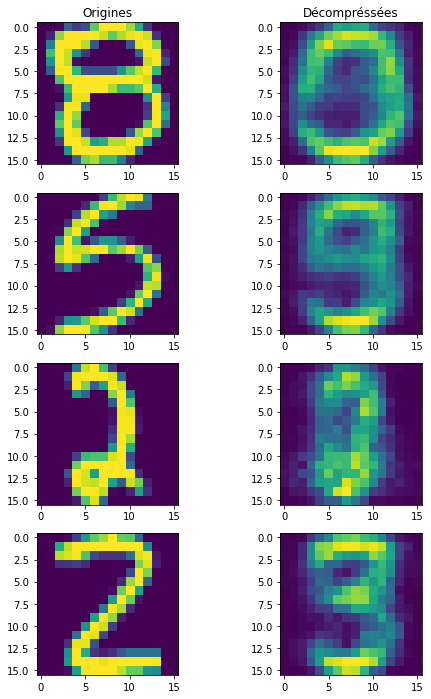

In [190]:
#On réduit le taux de compression
N = alltestx.shape[0]
L = 4
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompréssées")
for i in range(L):
    rand = np.random.randint(N)
    axs[i,0].imshow(alltestx[rand].reshape((16,16)))
    axs[i,1].imshow(uncomp1[rand].reshape((16,16)))

plt.show()

On peut voir qu'en réduisant le taux de compression, on perd moins d'information sur la décompression.

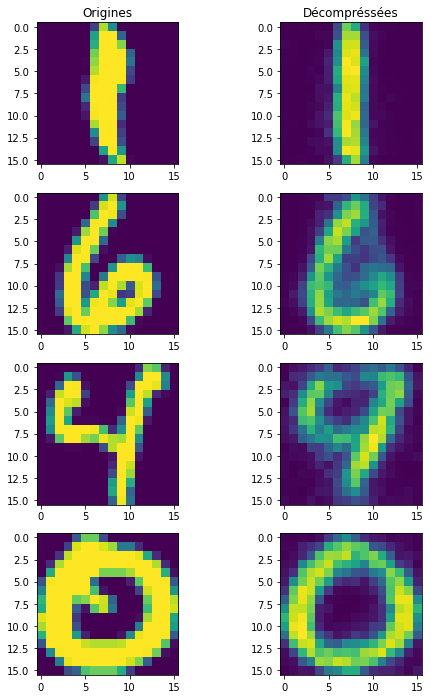

In [195]:
N = alltestx.shape[0]
L = 4
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompréssées")
for i in range(L):
    rand = np.random.randint(N)
    axs[i,0].imshow(alltestx[rand].reshape((16,16)))
    axs[i,1].imshow(uncomp2[rand].reshape((16,16)))

plt.show()

De même en compressant l'information plus doucement, on perd moins d'information.

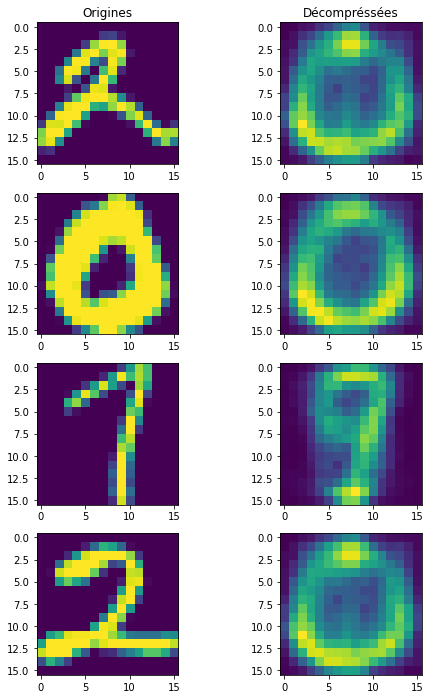

In [200]:
#Augmente le taux de compression.
N = alltestx.shape[0]
L = 4
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompréssées")
for i in range(L):
    rand = np.random.randint(N)
    axs[i,0].imshow(alltestx[rand].reshape((16,16)))
    axs[i,1].imshow(uncomp3[rand].reshape((16,16)))

plt.show()

Si on a un taux de compression trop grand, l'image est ruinée.

### Etude quantitative

On entraine un réseau de neurone a reconnaitre les images des chiffres. Ensuite on voit quel différence de taux de classification il y a entre les images d'origine et celles issues d'une compression/decompression.

In [247]:
y_train = np_utils.to_categorical(alltrainy) 
y_test = np_utils.to_categorical(alltesty)
y_train = y_train.reshape(y_train.shape[0],10)
y_test = y_test.reshape(y_test.shape[0],10)

In [251]:
clf = Sequentiel(OGCELoss())
clf.build_network([16*16,100,50,10],[Tanh(),Tanh(),SoftMax()])
opticlf = Optim(clf,1e-3)

In [252]:
SGD(opticlf,alltrainx,y_train, 60, 30,verbose = False)

#### Témoin

taux pred: 0.8819133034379671


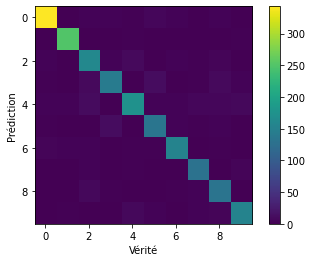

In [322]:
out = clf.forward(alltestx.reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

#### AutoEncoder Suggéré

taux pred: 0.48878923766816146


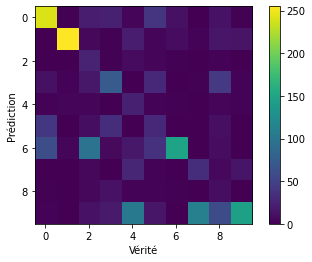

In [321]:
out = clf.forward(np.array(uncomp).reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

#### AutoEncoder avec taux de compression plus faible

taux pred: 0.624813153961136


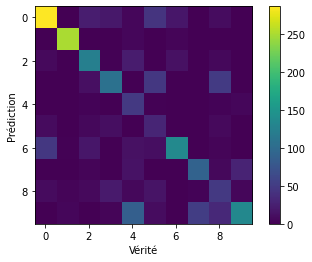

In [320]:
out = clf.forward(np.array(uncomp1).reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

#### AutoEncoder  avec compression plus douce

taux pred: 0.7065271549576483


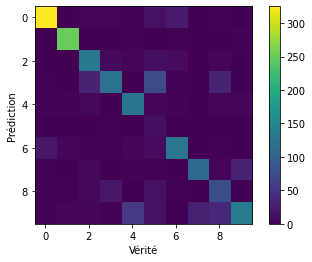

In [319]:
out = clf.forward(np.array(uncomp2).reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

#### AutoEncoder avec fort taux de compression

taux pred: 0.3188839063278525


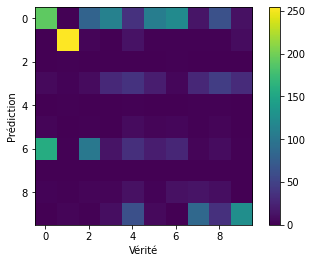

In [318]:
out = clf.forward(np.array(uncomp3).reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

En comparant avec l'AutoEncoder Suggéré dans le sujet (baseline), on voit que pour limiter la perte d'information, on peut soit limiter le taux de compression ou réaliser une compression en plus d'étape.

In [304]:
AE4 = AutoEncoder(BCELoss())
AE4.build([256,128,64,32,16,8],[8,16,32,64,128,256],[Tanh(),Tanh(),Tanh(),Tanh(),Tanh()],[Tanh(),Tanh(),Tanh(),Tanh(),Sigmoide()])
OptAE4 = Optim(AE4,1e-4)

In [305]:
SGD(OptAE4,alltrainx,alltrainx,20,500,lr = 1e-5,verbose = False)

In [306]:
code4 = AE4.encode(alltestx)
uncomp4 = AE4.decode(code4)

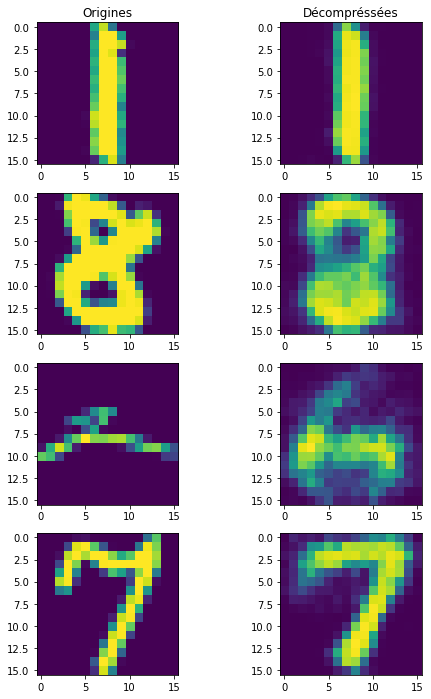

In [307]:
N = alltestx.shape[0]
L = 4
fig, axs = plt.subplots(L, 2,figsize=(8,3*L))
axs[0,0].set_title("Origines")
axs[0,1].set_title("Décompréssées")
for i in range(L):
    rand = np.random.randint(N)
    axs[i,0].imshow(alltestx[rand].reshape((16,16)))
    axs[i,1].imshow(uncomp4[rand].reshape((16,16)))

plt.show()

taux pred: 0.817140009965122


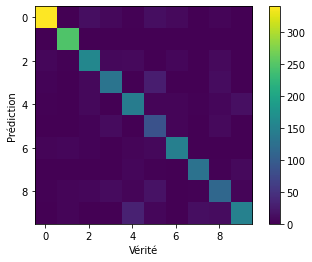

In [317]:
out = clf.forward(np.array(uncomp4).reshape(-1,1,256))
pred = np.argmax(out, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(y_test,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

On peut voir qu'on peu arriver a des images décompressée assez lisibles même en réduisant fortement la taille des données, 256 dimensions en origine, seulement 8 pour les données compressée.

De plus on passe d'un taux de bonne classification de 0.88% pour les données d'origine à 0.81% pour les données compressées puis décompressées.
L'écart entre les 2 taux n'est que de 7%.

## Partie 6 CNN

In [309]:
CNN = Sequentiel(OGCELoss())
CNN.add(Conv1D(3,1,32))
CNN.add(MaxPool1D(2,2))
CNN.add(Flatten())
CNN.add(Linear(4064,100))
CNN.add(ReLU())
CNN.add(Linear(100,10))
CNN.add(SoftMax())
optcnn = Optim(CNN,1e-5)

In [310]:
uspsdatatrain = "USPS_train.txt"
uspsdatatest = "USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
alltrainx = alltrainx/2
alltestx = alltestx/2

In [311]:
alltrainy = np_utils.to_categorical(alltrainy)
alltesty = np_utils.to_categorical(alltesty)

In [314]:
x_train = alltrainx.reshape(-1,256,1)
ind  = np.arange(x_train.shape[0])
np.random.shuffle(ind)

Pour limiter le temps d'exécution, on se restreint à 10 epochs sur 1000 exemples.

In [316]:
SGD(optcnn,x_train[ind][:1000],alltrainy[ind][:1000],20,10)

epoch : 1/10
erreur :  22.781260082076876
epoch : 2/10
erreur :  21.01266836840319
epoch : 3/10
erreur :  20.124923408220507
epoch : 4/10
erreur :  19.48099396005014
epoch : 5/10
erreur :  18.271251188964804
epoch : 6/10
erreur :  18.196016338890708
epoch : 7/10
erreur :  17.330121739695734
epoch : 8/10
erreur :  17.014119052272637
epoch : 9/10
erreur :  17.073951629414225
epoch : 10/10
erreur :  17.062388365991627


On peut voir qu'à chaque itération, la Loss diminue. \
Malheureusement, le code pour les réseaux de neurone convolutionnel n'est pas très optimisé, ajoutant à cela, le nombre de paramètres a apprendre, je n'ai pas pu réaliser beaucoup d'expérience sur les CNN.

In [331]:
pred = CNN.forward([alltestx.reshape(-1,256,1)])

taux pred: 0.39711011459890383


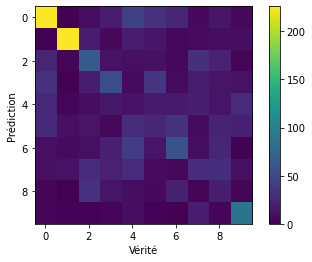

In [332]:
pred = np.argmax(pred, axis = 2)
pred = pred.reshape(-1)
y_true = np.argmax(alltesty,axis = 1)
taux = np.mean(np.where(pred == y_true,1,0))
print("taux pred:",taux)
confusion_mat(y_true,pred)

In [336]:
np.sum(alltesty,axis=0)/np.sum(alltesty)

array([0.17887394, 0.13153961, 0.09865471, 0.08271051, 0.09965122,
       0.07972097, 0.08470353, 0.07324365, 0.08271051, 0.08819133],
      dtype=float32)

On peut voir qu'en ne reonnaissant que les 0 et les 1, on arriverait seulement à 0.31% de taux de bonne prédiction.
On est presque à 40% de taux de bonne prédiction, ce qui correspond a peu près à la proportion des classes 0,1,9.

On peut voir que le CNN qu'en seulement 10 epochs sur 1000 exemples, le CNN arrive a reconnaitre les 0, les 1 et les 9. On peut aussi voir que le CNN commence à reconnaitre les 2,3 et 6, même si ce n'est pas très flagrant.